In [1]:
UPDATE = "asynchronous"
DIRECTORY = "models/random_nk3"
NUM_RUNS = 100
DEBUG = True

In [2]:
import os

import pystablemotifs.random_boolean_networks as rbn

N_NODES_LIST = [10]
GRAPHS_PER_SIZE = 100
# For K=2, use p=0.5, for K=3, use p=0.211325
K = 3  # in-degree
p = 0.211325 # ratio of 1 in the truth table

for N_NODES in N_NODES_LIST:
    rules_list = rbn.random_boolean_network_ensemble_kauffman(N_NODES,K,p,GRAPHS_PER_SIZE,seed=1000)

    for i in range(GRAPHS_PER_SIZE):
        rules = rules_list[i]
        
        rules = rules.replace(" *=", ",")
        rules = rules.replace(" and ", " & ")
        rules = rules.replace(" or ", " | ")
        rules = rules.replace("not ", "!")

        writePath = DIRECTORY + f"/n{N_NODES:03}_{i:03}.bnet"
        isExist = os.path.exists(DIRECTORY)
        if not isExist:
            os.makedirs(DIRECTORY)

        with open(writePath, "w") as f:
            f.write("targets, factors\n")
            f.write(rules)

In [ ]:
import numpy as np
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.trap_spaces import compute_trap_spaces
from pyboolnet.state_transition_graphs import primes2stg

from grouping import sd_grouping, null_grouping, random_grouping

def get_general_info(bnet, data={}, num_runs=100, DEBUG=False):

    # initialize data
    data["general"] = {}
    
    
    ### general information

    # read bnet and get primes, and sort them
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}

    # get number of nodes
    data["general"]["N"] = len(primes)

    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)

    # get number of percolated nodes
    data["general"]["N_perc"] = len(percolated_primes)

    if len(percolated_primes) == 0:
        return data
    
    # get percolated bnet
    percolated_bnet = primes2bnet(percolated_primes)

    # get number of sources
    sources = 0
    for node in primes:
        if primes[node] == [[{node: 0}], [{node: 1}]]:
            sources += 1
    data["general"]["sources"] = sources

    # get number of percolated sources
    sources_perc = 0
    for node in percolated_primes:
        if percolated_primes[node] == [[{node: 0}], [{node: 1}]]:
            sources_perc += 1
    data["general"]["sources_perc"] = sources_perc

    # get number of minimal trap spaces
    min_trap = compute_trap_spaces(percolated_primes, type_="min")
    data["general"]["min_trap"] = len(min_trap)


    ### grouping information

    # get sd grouping
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    sd_index_lengths = [len(sd_index) for sd_index in sd_indices]

    data["general"]["sd_group_size"] = len([x for x in sd_indices if x])
    data["general"]["sd_group_size_std"] = np.std(sd_index_lengths)

    # get null grouping
    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    data["general"]["null_group_size"] = len([x for x in null_indices if x])

    # get random grouping
    random_group_size_std = []
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        random_index_lengths = [len(random_index) for random_index in random_indices]
        random_group_size_std.append(np.std(random_index_lengths))
    data["general"]["random_group_size_mean_std"] = np.mean(random_group_size_std)

    return data

In [4]:
all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    # if filename != "n010_013.bnet":
    #     continue

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    all_data[filename] = get_general_info(bnet=content, data={}, num_runs=NUM_RUNS, DEBUG=DEBUG)


Reading file: n010_000.bnet
Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
sd_nodes=[{}, {'n2': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 1, 'n8': 1, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 1, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 1, 'n1': 1, 'n2': 0, 'n3': 0, 'n4': 1, 'n5': 1, 'n6': 0, 'n8': 0, 'n9': 0}]
sd_edges=[[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}], [{'n2': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n2': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}], [{'n0': 0, 'n2': 1, 'n6': 0, 'n8': 0}], [{'n0': 0, 'n

In [5]:
for filename in all_data:
    if all_data[filename]["general"]["N_perc"] == 0:
        continue
    print(filename,
          all_data[filename]["general"]["N"],
          all_data[filename]["general"]["N_perc"],
          all_data[filename]["general"]["sources"],
          all_data[filename]["general"]["sources_perc"],
          all_data[filename]["general"]["min_trap"],

          all_data[filename]["general"]["sd_group_size"],
          all_data[filename]["general"]["null_group_size"],

          all_data[filename]["general"]["sd_group_size_std"],
          all_data[filename]["general"]["random_group_size_mean_std"])

n010_000.bnet 10 10 0 0 2 16 3 36.259694318882026 14.034287205857174
n010_001.bnet 10 6 0 1 5 12 6 7.523001764957626 4.016746516444015
n010_002.bnet 10 7 0 0 1 5 2 19.043108989868223 13.079940822220797
n010_003.bnet 10 10 0 0 1 3 2 319.02176867557 240.97476841633107
n010_004.bnet 10 9 0 0 4 26 5 45.97270707624652 9.06555326767599
n010_005.bnet 10 6 0 0 1 1 1 0.0 0.0
n010_006.bnet 10 10 0 0 2 20 3 70.19150997494184 18.183839898537517
n010_007.bnet 10 9 0 0 2 19 3 22.23670196156399 10.178663612642312
n010_008.bnet 10 8 0 0 3 6 4 39.633525285175075 33.34647992368737
n010_009.bnet 10 8 0 0 2 4 3 56.50221234606659 45.1050383979126
n010_011.bnet 10 9 0 0 3 18 4 19.86924013648001 10.711912733604768
n010_012.bnet 10 10 0 0 1 5 2 101.90073601304358 102.72391855393671
n010_013.bnet 10 4 0 1 3 6 4 2.249716535431946 2.0244971525461404
n010_014.bnet 10 3 0 0 1 2 2 0.0 0.0
n010_015.bnet 10 10 0 0 6 30 7 69.62477719892537 17.2119564419282
n010_016.bnet 10 9 0 0 3 14 4 73.15122719966034 19.38246000776

In [ ]:
from transition_matrix import get_transition_matrix, get_uniform_matrix
from matrix_operations import compress_matrix, expand_matrix
from matrix_operations import nsquare
from matrix_operations import get_rms_diff, get_dkl
from matrix_operations import get_reachability
from matrix_operations import enforce_asynchronous

from scc_dags import get_scc_dag, get_ordered_states, get_attractor_states

def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["rmsd"] = {}
    data["dkl"] = {}
    data["reach"] = {}

    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}

    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)

    if len(percolated_primes) == 0:
        return data

    percolated_bnet = primes2bnet(percolated_primes)

    stg = primes2stg(percolated_primes, update)

    scc_dag = get_scc_dag(stg)
    scc_indices = get_ordered_states(scc_dag, as_indices=True)
    attractor_indices = get_attractor_states(scc_dag, as_indices=True)


    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_inf = nsquare(T, 20, DEBUG=DEBUG)

    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tm = compress_matrix(T, sd_indices, DEBUG=DEBUG)
    Tm_prime = expand_matrix(Tm, sd_indices, DEBUG=DEBUG)

    if update == "asynchronous":
        Tm_prime = enforce_asynchronous(Tm_prime, DEBUG=DEBUG)
    
    Tm_inf = nsquare(Tm, 20, DEBUG=DEBUG)
    Tm_inf_prime = expand_matrix(Tm_inf, sd_indices, DEBUG=DEBUG)

    data["rmsd"]["Tm"] = get_rms_diff(T, Tm_prime)
    data["dkl"]["Tm"] = get_dkl(T, Tm_prime)
    data["rmsd"]["Tm_inf"] = get_rms_diff(T_inf, Tm_inf_prime)
    data["dkl"]["Tm_inf"] = get_dkl(T_inf, Tm_inf_prime)

    data["reach"]["Tm"] = get_reachability(T, Tm_prime, DEBUG=DEBUG)
    data["reach"]["Tm_hier"] = get_reachability(T, Tm_prime, get_type="hierarchy", scc_indices=scc_indices, DEBUG=DEBUG)
    data["reach"]["Tm_inf"] = get_reachability(T_inf, Tm_inf_prime, DEBUG=DEBUG)
    data["reach"]["Tm_inf_att"] = get_reachability(T_inf, Tm_inf_prime, get_type="attractor", scc_indices=scc_indices, attractor_states=attractor_indices, DEBUG=DEBUG)
    data["reach"]["Tm_inf_basin"] = get_reachability(T_inf, Tm_inf_prime, get_type="basin", scc_indices=scc_indices, attractor_states=attractor_indices, DEBUG=DEBUG)

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    T0 = compress_matrix(T, null_indices, DEBUG=DEBUG)
    T0_prime = expand_matrix(T0, null_indices, DEBUG=DEBUG)

    if update == "asynchronous":
        T0_prime = enforce_asynchronous(T0_prime, DEBUG=DEBUG)

    T0_inf = nsquare(T0, 20, DEBUG=DEBUG)
    T0_inf_prime = expand_matrix(T0_inf, null_indices, DEBUG=DEBUG)

    data["rmsd"]["T0"] = get_rms_diff(T, T0_prime)
    data["dkl"]["T0"] = get_dkl(T, T0_prime)
    data["rmsd"]["T0_inf"] = get_rms_diff(T_inf, T0_inf_prime)
    data["dkl"]["T0_inf"] = get_dkl(T_inf, T0_inf_prime)

    data["reach"]["T0"] = get_reachability(T, T0_prime, DEBUG=DEBUG)
    data["reach"]["T0_hier"] = get_reachability(T, T0_prime, get_type="hierarchy", scc_indices=scc_indices, DEBUG=DEBUG)
    data["reach"]["T0_inf"] = get_reachability(T_inf, T0_inf_prime, DEBUG=DEBUG)
    data["reach"]["T0_inf_att"] = get_reachability(T_inf, T0_inf_prime, get_type="attractor", scc_indices=scc_indices, attractor_states=attractor_indices, DEBUG=DEBUG)
    data["reach"]["T0_inf_basin"] = get_reachability(T_inf, T0_inf_prime, get_type="basin", scc_indices=scc_indices, attractor_states=attractor_indices, DEBUG=DEBUG)

    U = get_uniform_matrix(2**(len(percolated_primes)))
    if update == "asynchronous":
        U = enforce_asynchronous(U, DEBUG=DEBUG)
    U_inf = get_uniform_matrix(2**(len(percolated_primes)))

    data["rmsd"]["U"] = get_rms_diff(T, U)
    data["dkl"]["U"] = get_dkl(T, U)
    data["rmsd"]["U_inf"] = get_rms_diff(T_inf, U_inf)
    data["dkl"]["U_inf"] = get_dkl(T_inf, U_inf)

    data["reach"]["U"] = get_reachability(T, U, DEBUG=DEBUG)
    data["reach"]["U_hier"] = get_reachability(T, U, get_type="hierarchy", scc_indices=scc_indices, DEBUG=DEBUG)
    data["reach"]["U_inf"] = get_reachability(T_inf, U_inf, DEBUG=DEBUG)
    data["reach"]["U_inf_att"] = get_reachability(T_inf, U_inf, get_type="attractor", scc_indices=scc_indices, attractor_states=attractor_indices, DEBUG=DEBUG)
    data["reach"]["U_inf_basin"] = get_reachability(T_inf, U_inf, get_type="basin", scc_indices=scc_indices, attractor_states=attractor_indices, DEBUG=DEBUG)


    rmsd = []
    dkl = []
    reach_TP = []
    reach_FP = []
    reach_TN = []
    reach_FN = []
    reach_hier_TP = []
    reach_hier_FP = []
    reach_hier_TN = []
    reach_hier_FN = []

    rmsd_inf = []
    dkl_inf = []
    reach_inf_TP = []
    reach_inf_FP = []
    reach_inf_TN = []
    reach_inf_FN = []
    reach_inf_att_TP = []
    reach_inf_att_FP = []
    reach_inf_att_TN = []
    reach_inf_att_FN = []
    reach_inf_basin_TP = []
    reach_inf_basin_FP = []
    reach_inf_basin_TN = []
    reach_inf_basin_FN = []



    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        TRm = compress_matrix(T, random_indices, DEBUG=DEBUG)
        TRm_prime = expand_matrix(TRm, random_indices, DEBUG=DEBUG)

        if update == "asynchronous":
            TRm_prime = enforce_asynchronous(TRm_prime, DEBUG=DEBUG)

        TRm_inf = nsquare(TRm, 20, DEBUG=DEBUG)
        TRm_inf_prime = expand_matrix(TRm_inf, random_indices, DEBUG=DEBUG)
        
        rmsd.append(get_rms_diff(T, TRm_prime))
        dkl.append(get_dkl(T, TRm_prime))
        reach = get_reachability(T, TRm_prime, DEBUG=DEBUG)
        reach_TP.append(reach[0])
        reach_FP.append(reach[1])
        reach_TN.append(reach[2])
        reach_FN.append(reach[3])
        reach_hier = get_reachability(T, TRm_prime, get_type="hierarchy", scc_indices=scc_indices, DEBUG=DEBUG)
        reach_hier_TP.append(reach_hier[0])
        reach_hier_FP.append(reach_hier[1])
        reach_hier_TN.append(reach_hier[2])
        reach_hier_FN.append(reach_hier[3])

        rmsd_inf.append(get_rms_diff(T_inf, TRm_inf_prime))
        dkl_inf.append(get_dkl(T_inf, TRm_inf_prime))
        reach_inf = get_reachability(T_inf, TRm_inf_prime, DEBUG=DEBUG)
        reach_inf_TP.append(reach_inf[0])
        reach_inf_FP.append(reach_inf[1])
        reach_inf_TN.append(reach_inf[2])
        reach_inf_FN.append(reach_inf[3])
        reach_inf_att = get_reachability(T_inf, TRm_inf_prime, get_type="attractor", scc_indices=scc_indices, attractor_states=attractor_indices, DEBUG=DEBUG)
        reach_inf_att_TP.append(reach_inf_att[0])
        reach_inf_att_FP.append(reach_inf_att[1])
        reach_inf_att_TN.append(reach_inf_att[2])
        reach_inf_att_FN.append(reach_inf_att[3])
        reach_inf_basin = get_reachability(T_inf, TRm_inf_prime, get_type="basin", scc_indices=scc_indices, attractor_states=attractor_indices, DEBUG=DEBUG)
        reach_inf_basin_TP.append(reach_inf_basin[0])
        reach_inf_basin_FP.append(reach_inf_basin[1])
        reach_inf_basin_TN.append(reach_inf_basin[2])
        reach_inf_basin_FN.append(reach_inf_basin[3])

    data["rmsd"]["TR"] = rmsd
    data["dkl"]["TR"] = dkl
    data["rmsd"]["TR_inf"] = rmsd_inf
    data["dkl"]["TR_inf"] = dkl_inf
    data["reach"]["TR_TP"] = reach_TP
    data["reach"]["TR_FP"] = reach_FP
    data["reach"]["TR_TN"] = reach_TN
    data["reach"]["TR_FN"] = reach_FN
    data["reach"]["TR_hier_TP"] = reach_hier_TP
    data["reach"]["TR_hier_FP"] = reach_hier_FP
    data["reach"]["TR_hier_TN"] = reach_hier_TN
    data["reach"]["TR_hier_FN"] = reach_hier_FN
    data["reach"]["TR_inf_TP"] = reach_inf_TP
    data["reach"]["TR_inf_FP"] = reach_inf_FP
    data["reach"]["TR_inf_TN"] = reach_inf_TN
    data["reach"]["TR_inf_FN"] = reach_inf_FN
    data["reach"]["TR_inf_att_TP"] = reach_inf_att_TP
    data["reach"]["TR_inf_att_FP"] = reach_inf_att_FP
    data["reach"]["TR_inf_att_TN"] = reach_inf_att_TN
    data["reach"]["TR_inf_att_FN"] = reach_inf_att_FN
    data["reach"]["TR_inf_basin_TP"] = reach_inf_basin_TP
    data["reach"]["TR_inf_basin_FP"] = reach_inf_basin_FP
    data["reach"]["TR_inf_basin_TN"] = reach_inf_basin_TN
    data["reach"]["TR_inf_basin_FN"] = reach_inf_basin_FN

    for key in ["rmsd", "dkl"]:
    # Calculate the mean and standard deviation
        mean = np.mean(data[key]["TR"])
        std_dev = np.std(data[key]["TR"])

        # Calculate the Z-score of the reference number
        if data[key]["Tm"] != data[key]["T0"]:
            z_score = (data[key]["Tm"] - mean) / std_dev
        else:
            z_score = np.nan

        data[key]["Tm_z"] = z_score

        mean = np.mean(data[key]["TR_inf"])
        std_dev = np.std(data[key]["TR_inf"])

        # Calculate the Z-score of the reference number
        if data[key]["Tm_inf"] != data[key]["T0_inf"]:
            z_score = (data[key]["Tm_inf"] - mean) / std_dev
        else:
            z_score = np.nan

        data[key]["Tm_inf_z"] = z_score

    return data

/tmp/ipykernel_50226/151729722.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    # if filename != "n010_032.bnet":
    #     continue

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    data = get_data(bnet=content, data=all_data[filename], update="asynchronous", num_runs=1, DEBUG=True)

    all_data[filename] = data

Reading file: n010_000.bnet


/tmp/ipykernel_50226/151729722.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (data[key]["Tm"] - mean) / std_dev
/tmp/ipykernel_50226/151729722.py:262: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (data[key]["Tm_inf"] - mean) / std_dev


Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
sd_nodes=[{}, {'n2': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 1, 'n8': 1, 'n9': 0}, {'n0': 0, 'n1': 0, 'n2': 1, 'n3': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 1, 'n1': 1, 'n2': 0, 'n3': 0, 'n4': 1, 'n5': 1, 'n6': 0, 'n8': 0, 'n9': 0}]
sd_edges=[[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}], [{'n2': 0, 'n4': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}, {'n0': 0, 'n2': 0, 'n5': 0, 'n6': 0, 'n8': 0, 'n9': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}], [{'n0': 0, 'n2': 1, 'n6': 0, 'n8': 0}], [{'n0': 0, 'n1': 0, 'n3': 0, 'n4': 0, 'n5

/tmp/ipykernel_50226/151729722.py:251: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (data[key]["Tm"] - mean) / std_dev


Reading file: n010_073.bnet
Reading file: n010_074.bnet
sd_nodes=[{}, {'n0': 0, 'n3': 0, 'n6': 0, 'n9': 1}, {'n0': 0, 'n3': 0, 'n6': 0, 'n7': 0, 'n8': 0, 'n9': 1}, {'n0': 0, 'n3': 0, 'n4': 0, 'n6': 0, 'n7': 1, 'n8': 0, 'n9': 1}, {'n0': 1, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 1, 'n5': 0, 'n6': 0, 'n7': 1, 'n8': 1, 'n9': 0}]
sd_edges=[[{'n0': 0, 'n6': 0, 'n9': 1}], [{'n0': 0, 'n3': 0, 'n6': 0, 'n7': 0, 'n9': 1}], [{'n0': 0, 'n3': 0, 'n6': 0, 'n7': 1, 'n9': 1}], [{'n0': 0, 'n3': 0, 'n4': 0, 'n7': 1}], [{'n0': 1, 'n2': 0, 'n3': 0, 'n4': 1, 'n5': 0, 'n6': 0, 'n7': 1, 'n8': 1, 'n9': 0}, {'n0': 1, 'n1': 0, 'n2': 0, 'n3': 0, 'n4': 1, 'n6': 0, 'n7': 1, 'n8': 1, 'n9': 0}]]
Duplicate state: 0000000111
SD edge: [{'n0': 0, 'n3': 0, 'n6': 0, 'n7': 1, 'n9': 1}]
SD edge: [{'n0': 0, 'n3': 0, 'n4': 0, 'n7': 1}]
Duplicate state: 0000010111
SD edge: [{'n0': 0, 'n3': 0, 'n6': 0, 'n7': 1, 'n9': 1}]
SD edge: [{'n0': 0, 'n3': 0, 'n4': 0, 'n7': 1}]
Duplicate state: 0010000111
SD edge: [{'n0': 0, 'n3': 0, 'n6': 0, 

In [4]:
for bnet in all_data:
    if all_data[bnet]["general"]["N_perc"] == 0:
        continue
    print(bnet,
          all_data[bnet]["general"]["N"],
          all_data[bnet]["general"]["N_perc"],
          all_data[bnet]["general"]["Tm_size"],
          all_data[bnet]["general"]["T0_size"],
          all_data[bnet]["rmsd"]["Tm"],
          np.mean(all_data[bnet]["rmsd"]["TR"]),
          all_data[bnet]["rmsd"]["T0"],
          all_data[bnet]["rmsd"]["U"],
          all_data[bnet]["dkl"]["Tm"],
          np.mean(all_data[bnet]["dkl"]["TR"]),
          all_data[bnet]["dkl"]["T0"],
          all_data[bnet]["dkl"]["U"],
          all_data[bnet]["rmsd"]["Tm_inf"],
          np.mean(all_data[bnet]["rmsd"]["TR_inf"]),
          all_data[bnet]["rmsd"]["T0_inf"],
          all_data[bnet]["rmsd"]["U_inf"],
          all_data[bnet]["dkl"]["Tm_inf"],
          np.mean(all_data[bnet]["dkl"]["TR_inf"]),
          all_data[bnet]["dkl"]["T0_inf"],
          all_data[bnet]["dkl"]["U_inf"],
          )

n010_000.bnet 10 10 16 3 0.015927011139626045 0.012168877037549928 0.01641110669426281 0.016536784549991596 930.2041222478447 641.9930620028729 1048.1886392871718 1080.9331731113211 0.007027910623418905 0.007740524176381077 0.007747708676980117 0.008676737797458964 689.2796356451446 1159.5068136734035 1163.2412151234073 4046.733486252779
n010_001.bnet 10 6 12 6 0.05561591735932875 0.04507057346508265 0.06219214759029146 0.06982164423707204 35.21991148645864 28.8420098135009 48.983454305864754 59.18800532127615 0.05557285145568359 0.07966678179613833 0.08116459066149971 0.09962067716551355 19.921570392796163 65.6729759286627 68.39184516322771 229.25201892189963
n010_002.bnet 10 7 5 2 0.04169433559203672 0.03723567037306076 0.04301022977676804 0.043626830994848355 94.75741376373708 79.03217210299653 104.6813736274677 106.7617793465986 0.0 0.0 0.0 0.08804240366863003 0.0 0.0 0.0 621.059873781711
n010_003.bnet 10 10 3 2 0.015027590757836676 0.014516670893580632 0.015080856594458921 0.01510

In [5]:
for bnet in all_data:
    if all_data[bnet]["general"]["N_perc"] == 0:
        continue
    print(bnet,
          all_data[bnet]["rmsd"]["Tm_z"],
          all_data[bnet]["dkl"]["Tm_z"],
          all_data[bnet]["rmsd"]["Tm_inf_z"],
          all_data[bnet]["dkl"]["Tm_inf_z"],
          all_data[bnet]["general"]["min_trap"],
          all_data[bnet]["general"]["sd_index_length_std"],
          np.mean(all_data[bnet]["general"]["random_index_length_std"]),
          )

n010_000.bnet inf inf -inf -inf 2 36.259694318882026 13.720422734012244
n010_001.bnet inf inf -inf -inf 5 7.523001764957626 3.9015666369065416
n010_002.bnet inf inf nan nan 1 19.043108989868223 13.35065541462291
n010_003.bnet inf inf nan nan 1 319.02176867557 240.66066474510444
n010_004.bnet inf inf -inf -inf 4 45.97270707624652 8.85684972110561
n010_005.bnet nan nan nan nan 1 0.0 0.0
n010_006.bnet inf inf -inf -inf 2 70.19150997494184 17.92093747547823
n010_007.bnet inf inf -inf -inf 2 22.23670196156399 10.409882370590413
n010_008.bnet inf inf -inf -inf 3 39.633525285175075 33.45976024354562
n010_009.bnet inf inf -inf -inf 2 56.50221234606659 45.21614755814564
n010_011.bnet inf inf -inf -inf 3 19.86924013648001 10.483967772122995
n010_012.bnet inf inf nan nan 1 101.90073601304358 102.41171807952448
n010_013.bnet -inf -inf -inf -inf 3 2.249716535431946 2.494438257849294
n010_014.bnet nan nan nan nan 1 0.0 0.0
n010_015.bnet inf inf -inf -inf 6 69.62477719892537 17.235106291778095
n010_0

In [6]:
for bnet in all_data:
    if all_data[bnet]["general"]["N_perc"] == 0:
        continue
    print(bnet,
          all_data[bnet]["reach"]["Tm"][0],
          all_data[bnet]["reach"]["Tm"][1],
          all_data[bnet]["reach"]["Tm"][2],
          all_data[bnet]["reach"]["Tm"][3],
          np.mean(all_data[bnet]["reach"]["TR_TP"]),
          np.mean(all_data[bnet]["reach"]["TR_FP"]),
          np.mean(all_data[bnet]["reach"]["TR_TN"]),
          np.mean(all_data[bnet]["reach"]["TR_FN"]),
          all_data[bnet]["reach"]["T0"][0],
          all_data[bnet]["reach"]["T0"][1],
          all_data[bnet]["reach"]["T0"][2],
          all_data[bnet]["reach"]["T0"][3],
          all_data[bnet]["reach"]["U"][0],
          all_data[bnet]["reach"]["U"][1],
          all_data[bnet]["reach"]["U"][2],
          all_data[bnet]["reach"]["U"][3],
          all_data[bnet]["reach"]["Tm_inf"][0],
          all_data[bnet]["reach"]["Tm_inf"][1],
          all_data[bnet]["reach"]["Tm_inf"][2],
          all_data[bnet]["reach"]["Tm_inf"][3],
          np.mean(all_data[bnet]["reach"]["TR_inf_TP"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_FP"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_TN"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_FN"]),
          all_data[bnet]["reach"]["T0_inf"][0],
          all_data[bnet]["reach"]["T0_inf"][1],
          all_data[bnet]["reach"]["T0_inf"][2],
          all_data[bnet]["reach"]["T0_inf"][3],
          all_data[bnet]["reach"]["U_inf"][0],
          all_data[bnet]["reach"]["U_inf"][1],
          all_data[bnet]["reach"]["U_inf"][2],
          all_data[bnet]["reach"]["U_inf"][3],
          )

n010_000.bnet 5632 3456 1039488 0 5632.0 5312.0 1037632.0 0.0 5632 5312 1037632 0 5632 5632 1037312 0 39424 5632 1003520 0 39424.0 24064.0 985088.0 0.0 39424 24064 985088 0 39424 1009152 0 0
n010_001.bnet 224 104 3768 0 224.0 178.0 3694.0 0.0 224 190 3682 0 224 224 3648 0 140 30 3926 0 140.0 216.0 3740.0 0.0 140 216 3740 0 140 3956 0 0
n010_002.bnet 560 332 15492 0 560.0 457.0 15367.0 0.0 560 457 15367 0 560 464 15360 0 128 0 16256 0 128.0 0.0 16256.0 0.0 128 0 16256 0 128 16256 0 0
n010_003.bnet 6144 4600 1037832 0 6144.0 5110.0 1037322.0 0.0 6144 5110 1037322 0 6144 5120 1037312 0 1024 0 1047552 0 1024.0 0.0 1047552.0 0.0 1024 0 1047552 0 1024 1047552 0 0
n010_004.bnet 2687 1493 257964 0 2687.0 2360.0 257097.0 0.0 2687 2397 257060 0 2687 2433 257024 0 1294 179 260671 0 1294.0 742.0 260108.0 0.0 1294 742 260108 0 1294 260850 0 0
n010_005.bnet 264 184 3648 0 264.0 184.0 3648.0 0.0 264 184 3648 0 264 184 3648 0 2560 1536 0 0 2560.0 1536.0 0.0 0.0 2560 1536 0 0 2560 1536 0 0
n010_006.bne

In [7]:
for bnet in all_data:
    if all_data[bnet]["general"]["N_perc"] == 0:
        continue
    print(bnet,
          all_data[bnet]["reach"]["Tm_hier"][0],
          all_data[bnet]["reach"]["Tm_hier"][1],
          all_data[bnet]["reach"]["Tm_hier"][2],
          all_data[bnet]["reach"]["Tm_hier"][3],
          np.mean(all_data[bnet]["reach"]["TR_hier_TP"]),
          np.mean(all_data[bnet]["reach"]["TR_hier_FP"]),
          np.mean(all_data[bnet]["reach"]["TR_hier_TN"]),
          np.mean(all_data[bnet]["reach"]["TR_hier_FN"]),
          all_data[bnet]["reach"]["T0_hier"][0],
          all_data[bnet]["reach"]["T0_hier"][1],
          all_data[bnet]["reach"]["T0_hier"][2],
          all_data[bnet]["reach"]["T0_hier"][3],
          all_data[bnet]["reach"]["U_hier"][0],
          all_data[bnet]["reach"]["U_hier"][1],
          all_data[bnet]["reach"]["U_hier"][2],
          all_data[bnet]["reach"]["U_hier"][3],
          all_data[bnet]["reach"]["Tm_inf_att"][0],
          all_data[bnet]["reach"]["Tm_inf_att"][1],
          all_data[bnet]["reach"]["Tm_inf_att"][2],
          all_data[bnet]["reach"]["Tm_inf_att"][3],
          np.mean(all_data[bnet]["reach"]["TR_inf_att_TP"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_att_FP"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_att_TN"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_att_FN"]),
          all_data[bnet]["reach"]["T0_inf_att"][0],
          all_data[bnet]["reach"]["T0_inf_att"][1],
          all_data[bnet]["reach"]["T0_inf_att"][2],
          all_data[bnet]["reach"]["T0_inf_att"][3],
          all_data[bnet]["reach"]["U_inf_att"][0],
          all_data[bnet]["reach"]["U_inf_att"][1],
          all_data[bnet]["reach"]["U_inf_att"][2],
          all_data[bnet]["reach"]["U_inf_att"][3],
          all_data[bnet]["reach"]["Tm_inf_basin"][0],
          all_data[bnet]["reach"]["Tm_inf_basin"][1],
          all_data[bnet]["reach"]["Tm_inf_basin"][2],
          all_data[bnet]["reach"]["Tm_inf_basin"][3],
          np.mean(all_data[bnet]["reach"]["TR_inf_basin_TP"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_basin_FP"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_basin_TN"]),
          np.mean(all_data[bnet]["reach"]["TR_inf_basin_FN"]),
          all_data[bnet]["reach"]["T0_inf_basin"][0],
          all_data[bnet]["reach"]["T0_inf_basin"][1],
          all_data[bnet]["reach"]["T0_inf_basin"][2],
          all_data[bnet]["reach"]["T0_inf_basin"][3],
          all_data[bnet]["reach"]["U_inf_basin"][0],
          all_data[bnet]["reach"]["U_inf_basin"][1],
          all_data[bnet]["reach"]["U_inf_basin"][2],
          all_data[bnet]["reach"]["U_inf_basin"][3],
          )

n010_000.bnet 0 1587 511080 0 0.0 3289.0 509378.0 0.0 0 3289 509378 0 0 3563 509104 0 1568 224 55552 0 1568.0 224.0 55552.0 0.0 1568 224 55552 0 1568 55776 0 0 37856 0 16352 0 37856.0 16128.0 224.0 0.0 37856 16128 224 0 37856 16352 0 0
n010_001.bnet 0 75 1877 0 0.0 122.0 1830.0 0.0 0 128 1824 0 0 160 1792 0 8 0 376 0 8.0 0.0 376.0 0.0 8 0 376 0 8 376 0 0 132 30 186 0 132.0 216.0 0.0 0.0 132 216 0 0 132 216 0 0
n010_002.bnet 0 236 7396 0 0.0 361.0 7271.0 0.0 0 361 7271 0 0 368 7264 0 1 0 127 0 1.0 0.0 127.0 0.0 1 0 127 0 1 127 0 0 127 0 0 0 127.0 0.0 0.0 0.0 127 0 0 0 127 0 0 0
n010_003.bnet 0 1439 340308 0 0.0 1949.0 339798.0 0.0 0 1949 339798 0 0 1959 339788 0 1 0 1023 0 1.0 0.0 1023.0 0.0 1 0 1023 0 1 1023 0 0 1023 0 0 0 1023.0 0.0 0.0 0.0 1023 0 0 0 1023 0 0 0
n010_004.bnet 0 999 126428 0 0.0 1797.0 125630.0 0.0 0 1824 125603 0 0 1859 125568 0 4 0 2044 0 4.0 0.0 2044.0 0.0 4 0 2044 0 4 2044 0 0 1290 179 563 0 1290.0 742.0 0.0 0.0 1290 742 0 0 1290 742 0 0
n010_005.bnet 0 64 1104 0 0

Figure where min_max is between sd and null (or max of the randoms)

In [8]:
import matplotlib.pyplot as plt

def plot_histogram1(data, title, xmax_rmsd=0.18, xmax_dkl=80, ymax=0.5):
    randoms = [np.array(data["rmsd"]["TR"]),
            np.array(data["dkl"]["TR"]),
            np.array(data["rmsd"]["TR_inf"]),
            np.array(data["dkl"]["TR_inf"])]

    sds = [data["rmsd"]["Tm"],
        data["dkl"]["Tm"],
        data["rmsd"]["Tm_inf"],
        data["dkl"]["Tm_inf"]]

    nulls = [data["rmsd"]["T0"],
            data["dkl"]["T0"],
            data["rmsd"]["T0_inf"],
            data["dkl"]["T0_inf"]]

    # print(sds)
    # print(nulls)

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 4))

    # Loop over each dataset and corresponding reference value
    for i, (ran, sd, null) in enumerate(zip(randoms, sds, nulls)):
        row, col = divmod(i, 2)  # Determine subplot position
        ax = axs[row, col]

        # Calculate the mean and standard deviation
        mean = np.mean(ran)
        std_dev = np.std(ran)

        # Calculate the Z-score of the reference number
        if sd != null:
            z_score = (sd - mean) / std_dev
        else:
            z_score = np.nan

        # binwidth = xmax_rmsd/100
        # if i == 1 or i == 3:
        #     binwidth = xmax_dkl/100

        # Create the histogram
        # hist, bins = np.histogram(ran, bins=np.arange(min(ran), max(ran) + binwidth, binwidth))
        hist, bins = np.histogram(ran, bins=10)

        # Calculate the ratio
        ratio = hist / hist.sum()

        if i == 2 or i == 3:
            inf = "∞"
        else:
            inf = ""

        # Plot histogram and reference line
        ax.bar(bins[:-1], ratio, width=np.diff(bins), align='edge', alpha=0.7)
        ax.axvline(sd, color='red', linestyle='-', linewidth=1, label=f'Tm{inf} (Z-score = {z_score:.2f})')
        ax.axvline(null, color='black', linestyle='-', linewidth=1, label='Null')
        # Adding lines for mean
        ax.axvline(mean, color='blue', linestyle='--', linewidth=1, label='Mean')

        # Set the labels, limits, and legend for each subplot
        ax.set_xlabel('Value')
        ax.set_ylabel('Ratio')
        # ax.set_ylim(0, ymax)
        ax.legend()

    axs[0,0].set_title("RMSD")
    axs[0,1].set_title("Dkl")
    axs[1,0].set_title("RMSD_inf")
    axs[1,1].set_title("Dkl_inf")

    # axs[0,0].set_xlim(-xmax_rmsd/100, xmax_rmsd)
    # axs[0,1].set_xlim(-xmax_dkl/100, xmax_dkl)
    # axs[1,0].set_xlim(-xmax_rmsd/100, xmax_rmsd)
    # axs[1,1].set_xlim(-xmax_dkl/100, xmax_dkl)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.suptitle(title)

    # Show the plot
    plt.show()

/tmp/ipykernel_50226/3332185655.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (sd - mean) / std_dev


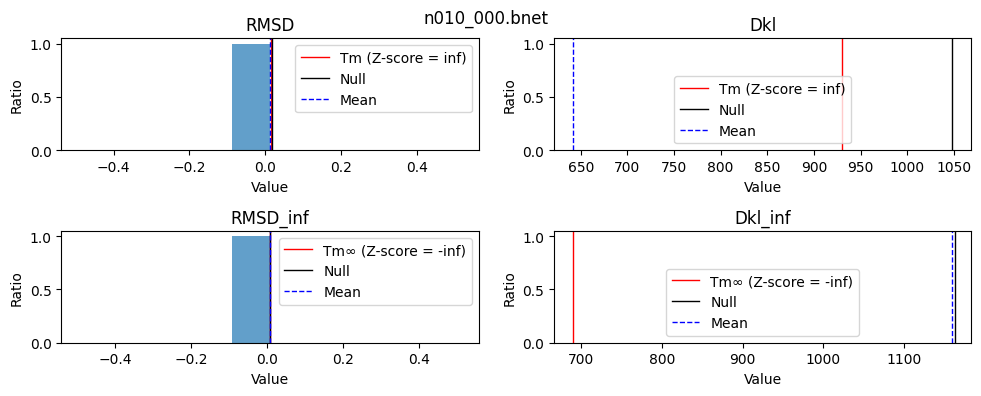

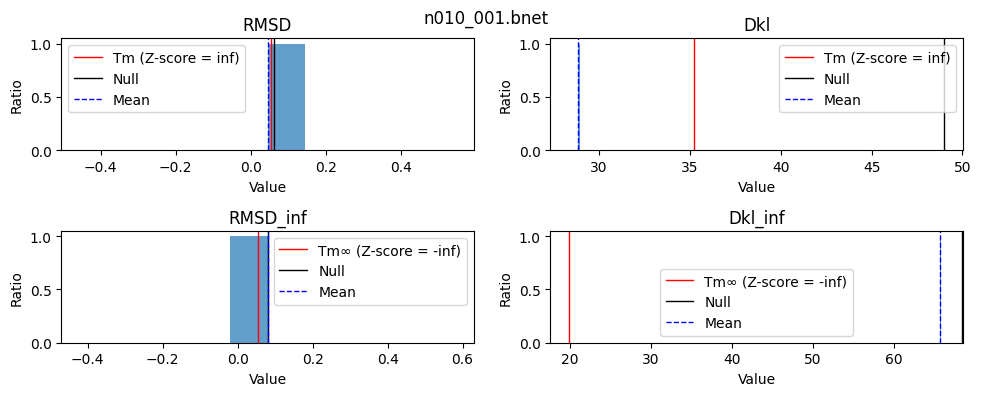

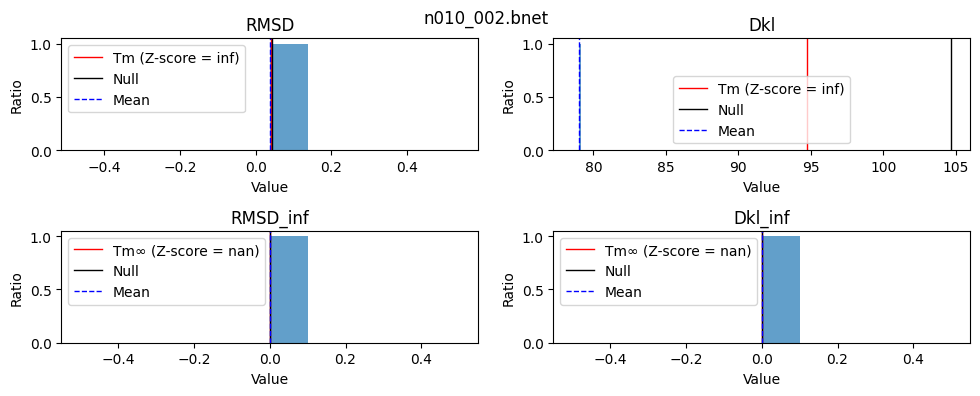

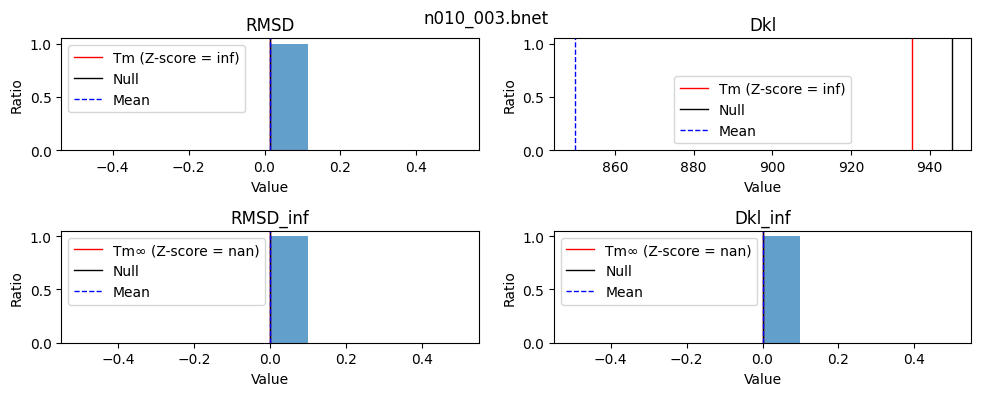

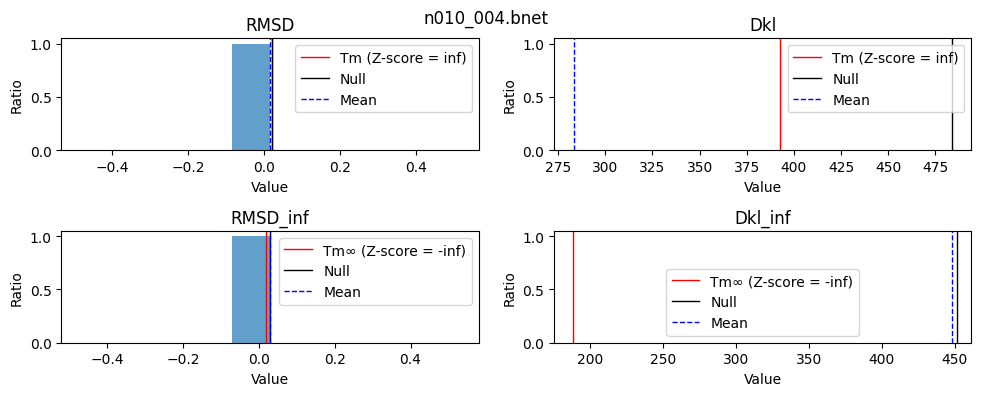

In [9]:
for i, bnet in enumerate(all_data):
    if i == 5:
        break
    plot_histogram1(all_data[bnet], title=bnet)


Figure where min_max is between sd and uniform

In [10]:
import matplotlib.pyplot as plt

def plot_histogram2(data, title, xmin=None, xmax_rmsd=0.18, xmax_dkl=80, ymax=0.5):
    randoms = [np.array(data["rmsd"]["TR"]),
            np.array(data["dkl"]["TR"]),
            np.array(data["rmsd"]["TR_inf"]),
            np.array(data["dkl"]["TR_inf"])]

    sds = [data["rmsd"]["Tm"],
        data["dkl"]["Tm"],
        data["rmsd"]["Tm_inf"],
        data["dkl"]["Tm_inf"]]

    nulls = [data["rmsd"]["T0"],
            data["dkl"]["T0"],
            data["rmsd"]["T0_inf"],
            data["dkl"]["T0_inf"]]

    uniforms = [data["rmsd"]["U"],
            data["dkl"]["U"],
            data["rmsd"]["U_inf"],
            data["dkl"]["U_inf"]]

    # print(sds)
    # print(nulls)

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 4))

    # Loop over each dataset and corresponding reference value
    for i, (ran, sd, null, uniform) in enumerate(zip(randoms, sds, nulls, uniforms)):
        row, col = divmod(i, 2)  # Determine subplot position
        ax = axs[row, col]

        # Calculate the mean and standard deviation
        mean = np.mean(ran)
        std_dev = np.std(ran)

        # Calculate the Z-score of the reference number
        if sd != null:
            z_score = (sd - mean) / std_dev
        else:
            z_score = np.nan

        # binwidth = xmax_rmsd/100
        # if i == 1 or i == 3:
        #     binwidth = xmax_dkl/100

        # Create the histogram
        # hist, bins = np.histogram(ran, bins=np.arange(min(ran), max(ran) + binwidth, binwidth))
        hist, bins = np.histogram(ran, bins=10)

        # Calculate the ratio
        ratio = hist / hist.sum()

        if i == 2 or i == 3:
            inf = "∞"
        else:
            inf = ""

        # Plot histogram and reference line
        ax.bar(bins[:-1], ratio, width=np.diff(bins), align='edge', alpha=0.7)
        ax.axvline(sd, color='red', linestyle='-', linewidth=1, label=f'Tm{inf} (Z-score = {z_score:.2f})')
        ax.axvline(null, color='black', linestyle='-', linewidth=1, label='Null')
        ax.axvline(uniform, color='purple', linestyle='-', linewidth=1, label='Uniform')
        # Adding lines for mean
        ax.axvline(mean, color='blue', linestyle='--', linewidth=1, label='Mean')

        # Set the labels, limits, and legend for each subplot
        ax.set_xlabel('Value')
        ax.set_ylabel('Ratio')
        # ax.set_ylim(0, ymax)
        ax.legend()

        if xmin != None:
            ax.set_xlim(left=xmin)

    axs[0,0].set_title("RMSD")
    axs[0,1].set_title("Dkl")
    axs[1,0].set_title("RMSD_inf")
    axs[1,1].set_title("Dkl_inf")

    # axs[0,0].set_xlim(-xmax_rmsd/100, xmax_rmsd)
    # axs[0,1].set_xlim(-xmax_dkl/100, xmax_dkl)
    # axs[1,0].set_xlim(-xmax_rmsd/100, xmax_rmsd)
    # axs[1,1].set_xlim(-xmax_dkl/100, xmax_dkl)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.suptitle(title)

    # Show the plot
    plt.show()

/tmp/ipykernel_50226/1944651286.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (sd - mean) / std_dev


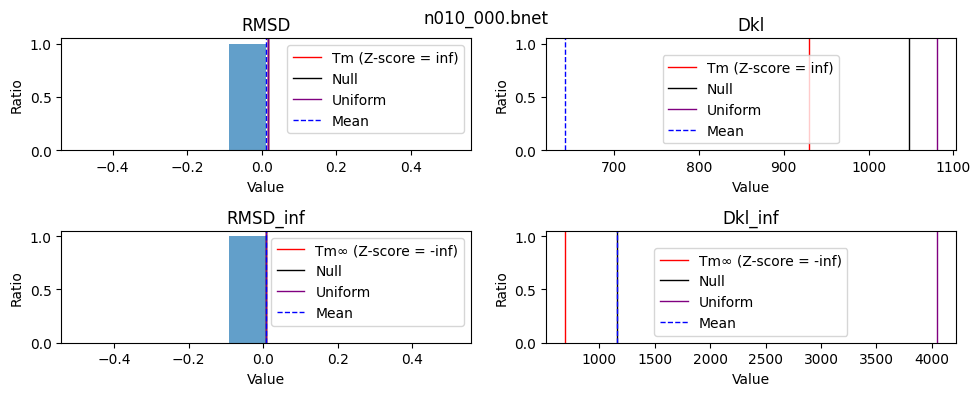

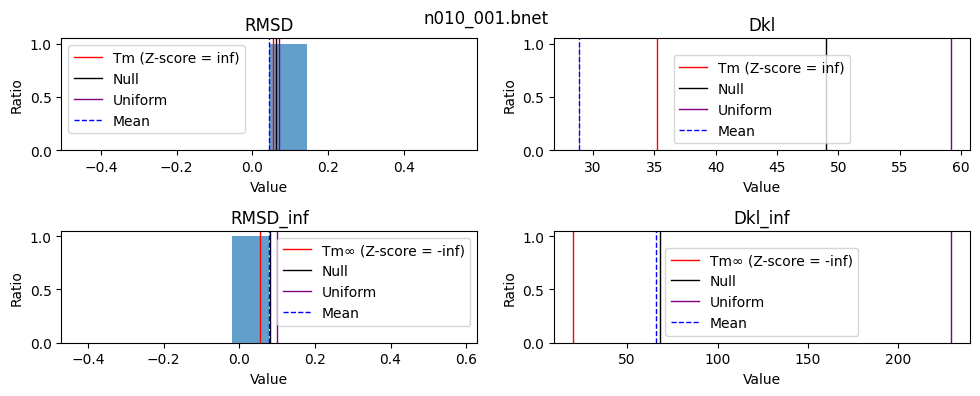

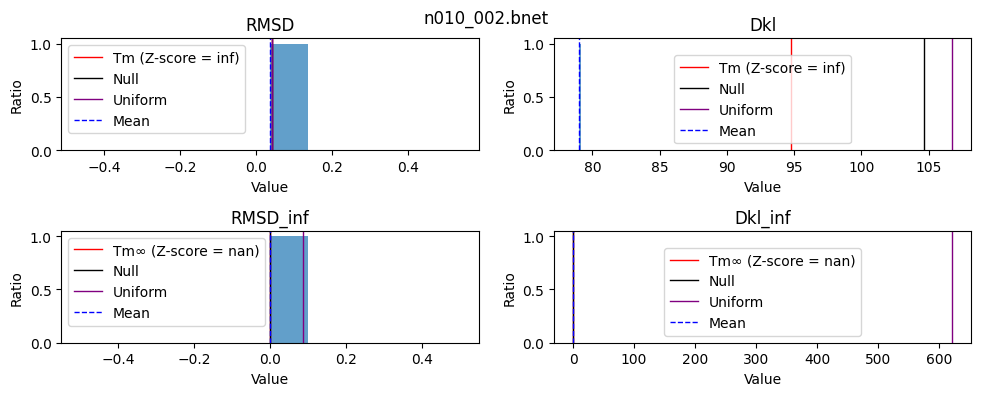

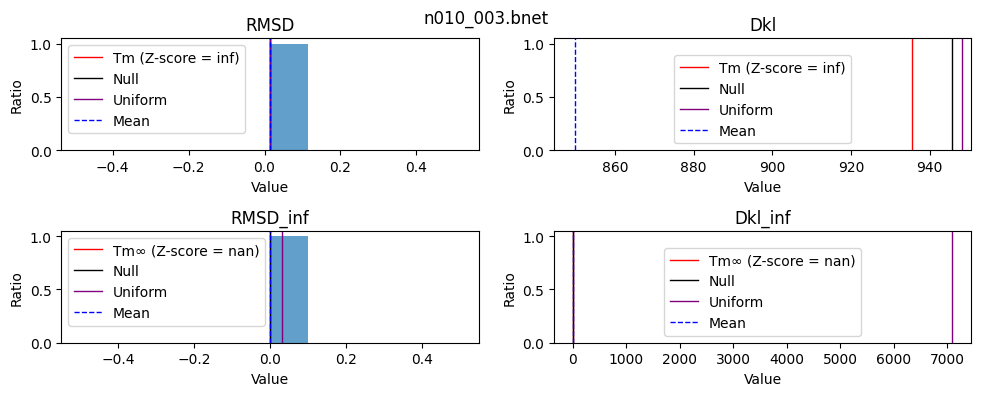

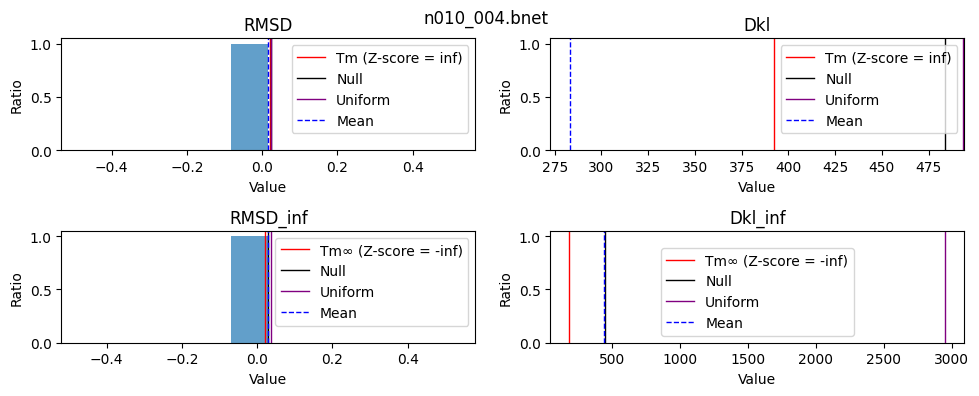

In [11]:
for i, bnet in enumerate(all_data):
    if i == 5:
        break
    plot_histogram2(all_data[bnet], title=bnet)

/tmp/ipykernel_50226/1944651286.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (sd - mean) / std_dev


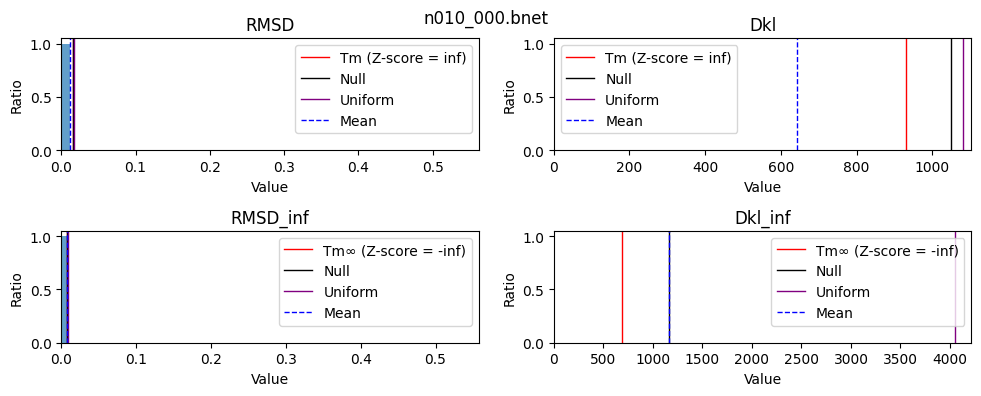

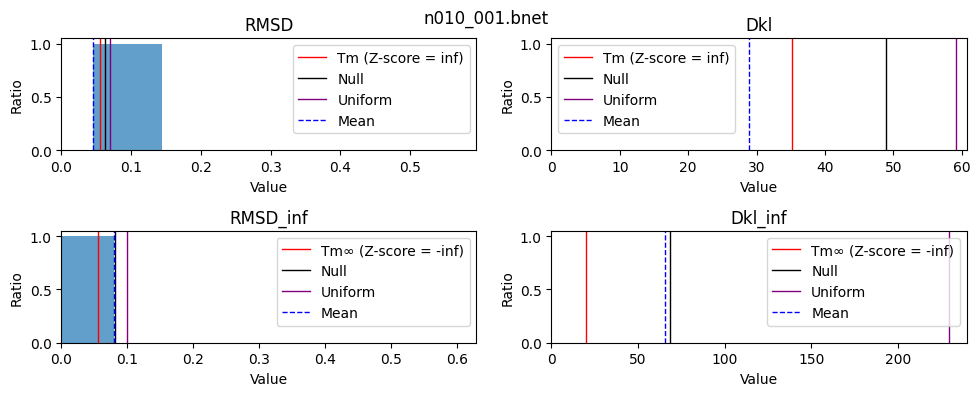

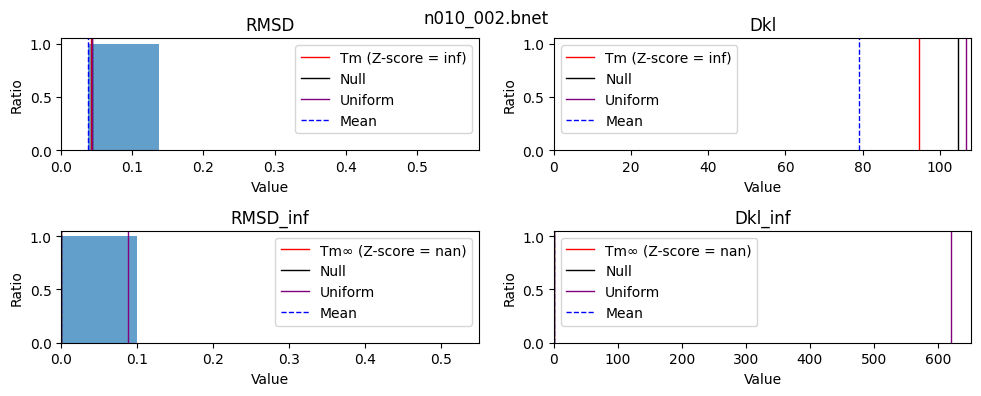

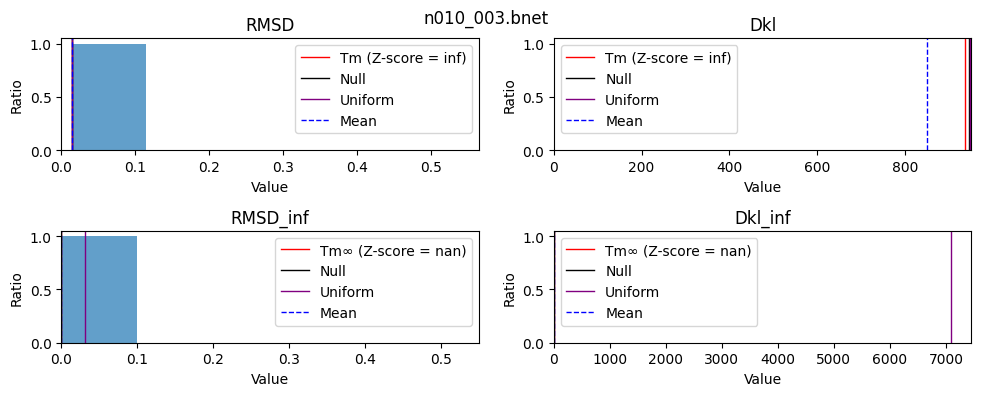

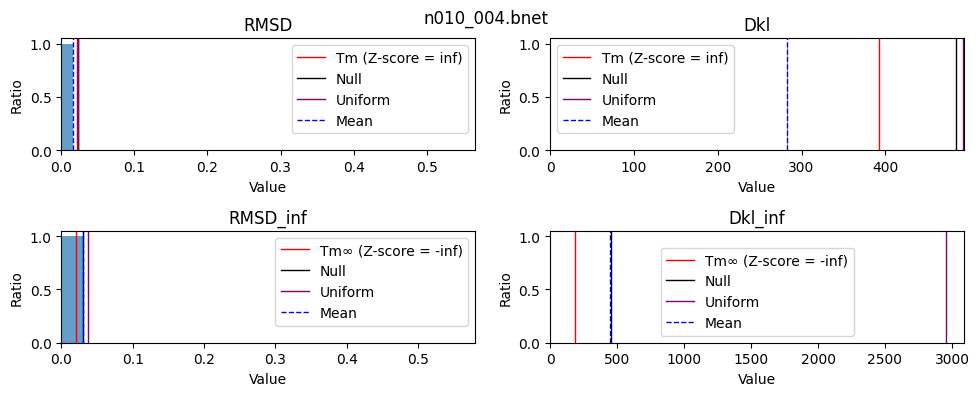

In [12]:
for i, bnet in enumerate(all_data):
    if i == 5:
        break
    plot_histogram2(all_data[bnet], title=bnet, xmin=0)